In [ ]:
# package
import sys
sys.path.append('..')
import argparse
import os
import sys
import A_1k_arg_sampling as sampling
from A_1k_arg_sampling import ReverseDiffusionPredictor,LangevinCorrector,AnnealedLangevinDynamics ,EulerMaruyamaPredictor,AncestralSamplingPredictor
import aapm_sin_ncsnpp_gb as configs
sys.path.append('..')
from losses import get_optimizer
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint
from models import utils as mutils
from sde_lib import VESDE, VPSDE, subVPSDE

In [ ]:
# args
parser = argparse.ArgumentParser()
parser.add_argument('--size', type=int, default=500)
parser.add_argument('--gap', type=int, default=60)
parser.add_argument('--useNet', type=bool, default=True)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--ssn', type=int, default=-1)
args = parser.parse_args()
ssnContent=""
if args.ssn != -1:
  ssnContent = f" | ssn {args.ssn}"
os.environ["CUDA_VISIBLE_DEVICES"] = f"{args.gpu}"

size 500 gap 60 Net True sparse False amp 0  psnr 14.9700  ssim 0.6122  mse 0.0318
size 500 gap 60 Net True sparse False phase 0  psnr 14.1700 ssim 0.3567  mse 0.0383
size 500 gap 60 Net True sparse False amp 5  psnr 16.1300  ssim 0.6715  mse 0.0244
size 500 gap 60 Net True sparse False phase 5  psnr 14.5800 ssim 0.3674  mse 0.0349
size 500 gap 60 Net True sparse False amp 10  psnr 16.7300  ssim 0.6963  mse 0.0213
size 500 gap 60 Net True sparse False phase 10  psnr 14.9000 ssim 0.3873  mse 0.0324
size 500 gap 60 Net True sparse False amp 15  psnr 17.2400  ssim 0.7163  mse 0.0189
size 500 gap 60 Net True sparse False phase 15  psnr 15.1900 ssim 0.4052  mse 0.0303
size 500 gap 60 Net True sparse False amp 20  psnr 17.7100  ssim 0.7371  mse 0.0169
size 500 gap 60 Net True sparse False phase 20  psnr 15.5400 ssim 0.4235  mse 0.0279
size 500 gap 60 Net True sparse False amp 25  psnr 18.2100  ssim 0.7589  mse 0.0151
size 500 gap 60 Net True sparse False phase 25  psnr 16.0100 ssim 0.4458  m

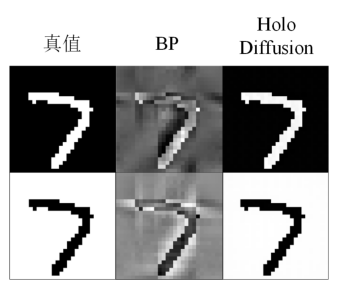

In [24]:
# test

def get_predict(num):
  if num == 0:
    return None
  elif num == 1:
    return EulerMaruyamaPredictor
  elif num == 2:
    return ReverseDiffusionPredictor

def get_correct(num):
  if num == 0:
    return None
  elif num == 1:
    return LangevinCorrector
  elif num == 2:
    return AnnealedLangevinDynamics

predicts = [2]
corrects = [1]
checkpoint_num = [20]
for predict in predicts:
  for correct in corrects:
    for check_num in checkpoint_num:
      sde = 'VESDE'
      if sde.lower() == 'vesde':
        ckpt_filename = './exp/checkpoints/checkpoint_{}.pth'.format(check_num)
        assert os.path.exists(ckpt_filename)
        config = configs.get_config()
        sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
        sampling_eps = 1e-5

      batch_size = 1
      config.training.batch_size = batch_size
      config.eval.batch_size = batch_size

      random_seed = 0

      sigmas = mutils.get_sigmas(config)
      score_model = mutils.create_model(config)

      optimizer = get_optimizer(config, score_model.parameters())
      ema = ExponentialMovingAverage(score_model.parameters(),
                                    decay=config.model.ema_rate)
      state = dict(step=0, optimizer=optimizer,
                  model=score_model, ema=ema)

      state = restore_checkpoint(ckpt_filename, state, config.device)
      ema.copy_to(score_model.parameters())

      img_size = config.data.image_size
      channels = config.data.num_channels
      shape = (batch_size, channels, img_size, img_size)
      predictor = get_predict(predict)
      corrector = get_correct(correct)

      snr = 0.075
      n_steps =  1
      probability_flow = False

      sampling_fn = sampling.get_pc_sampler(sde, predictor, corrector,
                                            None, snr, n_steps=n_steps,
                                            probability_flow=probability_flow,
                                            continuous=config.training.continuous,
                                            eps=sampling_eps, device=config.device, zl_arg = args)

      sampling_fn(score_model,check_num,predict,correct)

